In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import normaltest, skew, kurtosis
from sklearn.metrics import mean_absolute_error, make_scorer, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pymorphy2 import MorphAnalyzer

%matplotlib inline
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Содержание

1. Описание набора данных и признаков
2. Первичный анализ данных
3. Первичный визуальный анализ данных
4. Инсайты и закономерности
5. Выбор метрики
6. Выбор модели
7. Предобработка данных
8. Кросс-валидация и настройка гиперпараметров модели
9. Построение кривых валидации и обучения
11. Прогноз для отложенной выборке
12. Выводы

### 1. Описание набора данных и признаков

#### Задача:


 1. Необходимо реализовать модель на основе предоставленного датасета "АВСОФТ_тест_ML_приложение.csv"
    

### Признаки:

- **repository_name** - имя репозитория
- **commit_hash** - идентификатор коммита
- **commit_date** - дата коммита
- **commit_author** - автор коммита
- **commit_message** - комментарий к коммиту


### Целевая переменная:
 
 `bugs` 

Считаем данные

In [2]:
data = pd.read_csv('АВСОФТ_тест_ML_приложение.csv')

In [3]:
data.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
repository_name    319 non-null object
commit_hash        319 non-null object
commit_date        319 non-null object
commit_author      319 non-null object
commit_message     319 non-null object
bugs               319 non-null int64
dtypes: int64(1), object(5)
memory usage: 15.0+ KB


### 2. Первичный анализ данных

In [5]:
data.describe(include=['object'])

,repository_name,commit_hash,commit_date,commit_author,commit_message
count,319,319,319,319,319
unique,6,319,318,10,309
top,conductor,34c1e635,2020-06-10T10:17:03,Victor,Merge branch 'changes-to-merge' into 'master'
freq,114,1,2,134,4


In [6]:
data.describe()

,bugs
count,319.000000
mean,2.996865
std,1.855636
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,12.000000


У нас один вещественный признак (целевой), остальные - категориальные. Среднее значение количества ошибок - 3. Между верхним квартилем и максимальным значением есть довольно высокая разница, видимо могут присуствовать какие-то выбросы.

### Распределение целевого признака

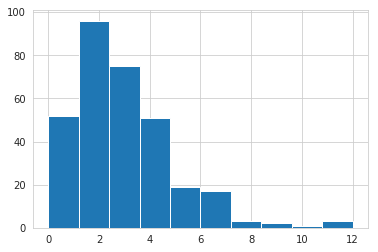

In [7]:
plt.hist(data.bugs);

#### Проверим на нормальность и скошенность

In [8]:
normaltest_result = normaltest(data.bugs)
print(f"Нормальность: {normaltest_result.pvalue}") 

Нормальность: 4.0542457095442116e-27


In [9]:
print(f"Скошенность: {skew(data.bugs)}")

Скошенность: 1.6696652404210477


#### Пропуски

In [10]:
null_content = data.isnull().sum()

In [11]:
null_content

repository_name    0
commit_hash        0
commit_date        0
commit_author      0
commit_message     0
bugs               0
dtype: int64

В нашем датасете нет пропусков, значит можно идти дальше

### 3. Первичный визуальный анализ данных

Оценим влияние наших признаков на количество ошибок. Для этого найдём медиану целевого признака для каждого признака.

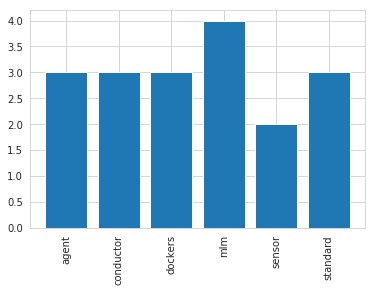

In [12]:
median_targer_for_repository_name = data.groupby(['repository_name']).bugs.median()
plt.xticks(rotation=90)
plt.bar(height = median_targer_for_repository_name, x = median_targer_for_repository_name.index);

В mlm случаются чаще ошибки, но не сказать, чтобы уж прям шибко. В этой категории мы не можем судить о какой-то явной корреляции с количеством ошибок в зависимости от имени репозитория, попробуем посмотреть на другие признаки 

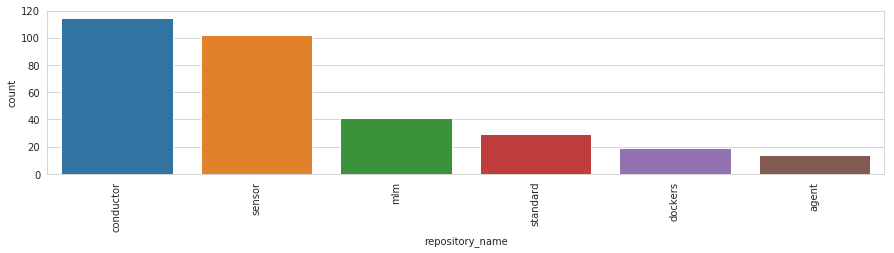

In [13]:
plt.figure(figsize=(15,3))
plt.xticks(rotation=90)
sns.countplot(data=data, x='repository_name', 
              order=data.repository_name.value_counts().index);

Видно, что чаще всего корректируются репозитории с именем `conductor` и `sensor`. Кстати, исходя из двух оценок выше, можно сделать вывод, что правки в репозиторие `sensor` являются более эффективными, чем, в репозитории `conductor`.

Построим диаграмму по количеству правок в зависимости от авторов коммита

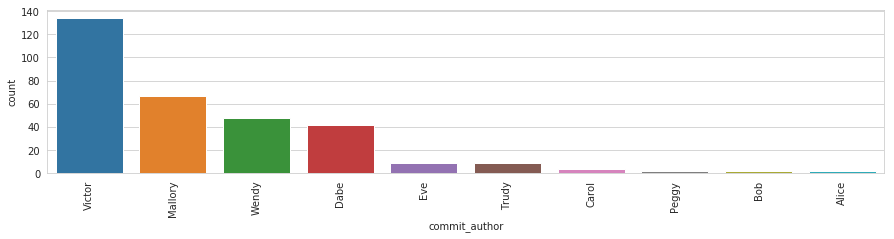

In [14]:
plt.figure(figsize=(15,3))
plt.xticks(rotation=90)
sns.countplot(data=data, x='commit_author', 
              order=data.commit_author.value_counts().index);

Виктор чаще всего вносил правки.

Создадим массив авторов репозиториев, которые осуществляли больше 20 правок и проверим насколько эффективными были эти правки в зависимости от автора 

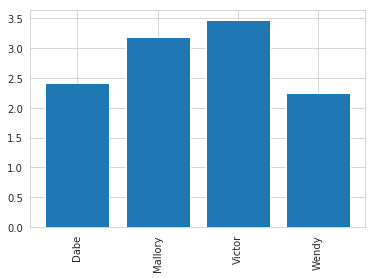

In [15]:
d = ['Victor', 'Mallory', 'Wendy', 'Dabe']
median_targer_for_commit_author = data[data['commit_author'].isin(d)].groupby(['commit_author']).bugs.mean()
plt.xticks(rotation=90)
plt.bar(height = median_targer_for_commit_author, x = median_targer_for_commit_author.index);

На самом деле, мы не можем делать какие-то конкретные выводы по этой метрике, так как, с ростом количества правок растёт и среднее количество багов, а Dabe и Wendy делали меньше правок, чем остальные двое.

### 4. Инсайты и закономерности

Обобщим наши наблюдения:


- чаще всего вносят правки в репозитории с именами `Conductor` и `Sensor`
- в `mlm` чаще всего возникают ошибки
- правки в репозитории `sensor` являются заметно более эффективными по сравнению с остальными
- можно выделить 4-ёх сотрудников, которые чаще всего вносят правки: Victor, Mallory, Dabe, Wendy
- с количеством внесённых правок одним сотрудником растёт и его общее количество ошибок

### 5. Выбор метрики

Для оценки качества модели будет использовать F1 score, как что-то среднее гармоническое между precision и recall.
Хотя ещё попробую взять метрику accuracy.

In [16]:
from sklearn.metrics import f1_score

### 6. Выбор модели

У нас не так много данных, и, думаю, задача больше стоит предсказать примерное количество ошибок, поэтому решил целевую переменную разделить на классы: если количество ошибок в коммите <= 4 -> 0; <= 8 -> 1; иначе - 2

Попробую использовать модель RandomForestClassifier


### 7. Предобработка данных

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

Сортируем наши записи по дате

In [18]:
data.index = data.commit_date
data.sort_index(inplace=True)

In [19]:
data.index = pd.to_datetime(data.commit_date)


Создаём несколько признаков: недели, часы, месяцы. Удаляем признак дата. 

In [20]:
data['weekday'] = data.index.weekday
data['hours'] = data.index.hour
data['month'] = data.index.month

In [21]:
data.index = data.commit_hash
data = data.drop(columns=['commit_hash'])

In [22]:
data.commit_date = pd.to_datetime(data.commit_date)

Кодируем категориальные признаки `repository_name` и `commit_author` с помощью техники One-Hot-Encoding

In [23]:
data = pd.concat([
    data,
    pd.get_dummies(data['repository_name'], prefix = 'repository'),
    pd.get_dummies(data['commit_author'], prefix = 'author')
], axis = 1)
data.drop(
    [
        'repository_name',
        'commit_author',
        'commit_date'
    ],
    axis = 1,
    inplace = True
)

Далее, я обработал признак `commit_message`(лемматизировал, токкенизировал), но работать с ним пока не стал.

In [ ]:
data.commit_message = data.commit_message.str.lower()
data.commit_message = data.commit_message.str.replace('[^A-Za-z0-9]+', ' ', regex=True)

Импортируем библаотеку nltk, скачиваем стоп слова

In [25]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gennadiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gennadiy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/gennadiy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
stopwords = stopwords.words('english')

In [27]:
def stop_words(text):
    return ' '.join(word for word in text.split() if word not in stopwords)

Удаляем стоп слова

In [28]:
data['commit_message'] = data.commit_message.apply(stop_words)

Проводим токкенизацию и лемматизацию текста

In [29]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lem_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
data['lemmatized_tokens'] = data['commit_message'].apply(lem_text)

In [30]:
data.drop(columns='commit_message', axis=1, inplace=True)

In [31]:
data['len_commit'] = data.lemmatized_tokens.apply(lambda x: len(x))

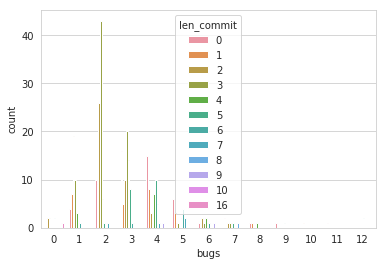

In [32]:
sns.countplot(x='bugs', hue='len_commit', data=data);

Категоризируем признак `bugs`

In [33]:
def cat_bugs(num):
    if num <= 4:
        return 0
    elif num <= 8:
        return 1
    return 2

In [34]:
data['bugs'] = data.bugs.apply(cat_bugs)

In [35]:
data.head()

,bugs,weekday,hours,month,repository_agent,repository_conductor,repository_dockers,repository_mlm,repository_sensor,repository_standard,...,author_Carol,author_Dabe,author_Eve,author_Mallory,author_Peggy,author_Trudy,author_Victor,author_Wendy,lemmatized_tokens,len_commit
commit_hash,,,,,,,,,,,,,,,,,,,,,
79db41fb,0,6,14,3,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[initial, commit]",2
bfa1152f,1,6,15,3,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[jsonmaster, function, separator]",3
29ba5151,2,6,17,3,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[small, fix, model, py, make, work]",6
a8b55539,0,6,17,3,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[added, gitignore]",2
bb54e4e6,2,6,17,3,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[small, fix, main, py, make, work]",6


### 8. Кросс-валидация и настройка гиперпараметров модели

In [36]:
X = data.drop(columns=['bugs', 'lemmatized_tokens'], axis=1)

In [37]:
y = data.bugs

In [38]:
X_train, X_holdout, y_train,  y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

In [39]:
X_train.shape, X_holdout.shape, y_train.shape,  y_holdout.shape

((223, 20), (96, 20), (223,), (96,))

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, validation_curve, learning_curve, StratifiedKFold

In [53]:
rfc = RandomForestClassifier(oob_score=True)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(rfc, parametrs, cv=skf)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(10, 51, 10), 'max_depth': range(1, 13, 2), 'min_samples_leaf': range(1, 8), 'min_samples_split': range(2, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
grid.best_params_, grid.best_score_

({'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 0.8834080717488789)

Получаем accuracy = 88%, что считаю очень даже неплохо.

Построим feature_importance

In [55]:
feat_importance = pd.DataFrame(X_train.columns, columns = ['features'])
feat_importance['value'] = grid.best_estimator_.feature_importances_
feat_importance.sort_values('value')[::-1]

,features,value
19,len_commit,0.269699
1,hours,0.154278
6,repository_mlm,0.130900
0,weekday,0.113875
2,month,0.069401
7,repository_sensor,0.067311
17,author_Victor,0.047444
13,author_Eve,0.040373
4,repository_conductor,0.027292
14,author_Mallory,0.018681


Удивительно, но самым важным признаком оказалась длина коммита, немного ожидаемо - часы, то бишь, возможно, это как-то связано с распорядком дня.

### 9. Построение кривых валидации и обучения 

In [56]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

<b>Построим кривые валидации</b>, будем менять сложность модели изменяя параметры.

In [57]:
f1_scorer = make_scorer(f1_score, average='micro')
rf_val = RandomForestClassifier(class_weight='balanced', random_state=17)

Посмотрим на зависимость от числа деревьев.

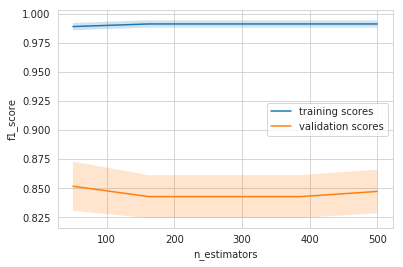

In [58]:
n = np.linspace(50, 500, 5).astype(int)

val_train, val_test = validation_curve(rf_val, X_train, y_train,
                                       'n_estimators', n, cv=skf,
                                       scoring=f1_scorer, n_jobs=-1)

plot_with_err(n, val_train, label='training scores')
plot_with_err(n, val_test, label='validation scores')
plt.xlabel('n_estimators'); plt.ylabel('f1_score')
plt.legend();

Посмотрим на зависимость от числа объектов в листе.

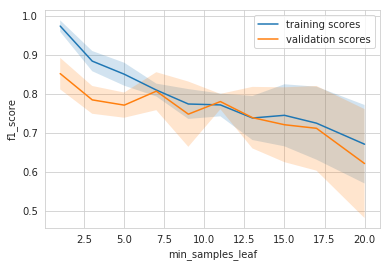

In [59]:
n = np.linspace(1, 20, 10).astype(int)

val_train, val_test = validation_curve(rf_val, X_train, y_train,
                                       'min_samples_leaf', n, cv=skf,
                                       scoring=f1_scorer, n_jobs=-1)

plot_with_err(n, val_train, label='training scores')
plot_with_err(n, val_test, label='validation scores')
plt.xlabel('min_samples_leaf'); plt.ylabel('f1_score')
plt.legend();

При 7 объектах в листе, мы наблюдаем значительное повышение оценки качеста, но всё же имеем, что при увеличении количества объектов в листе качесво модели падает

<b>Построим обучающие кривые. </b>

In [60]:
def plot_learning_curve(min_samples_leaf=2, n_estimators=500):
    train_sizes = np.linspace(0.05, 1, 100)
    
    rf_learn = RandomForestClassifier(class_weight='balanced', min_samples_leaf=min_samples_leaf, n_estimators = n_estimators)
    N_train, val_train, val_test = learning_curve(rf_learn, X_train, y_train, train_sizes=train_sizes, cv=skf,
                                                  scoring=f1_scorer, n_jobs=-1)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('f1 score')
    plt.legend()

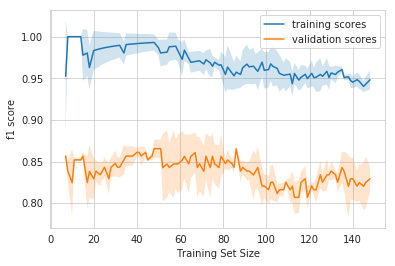

In [61]:
plot_learning_curve()

In [63]:
best_rf = grid.best_estimator_

In [64]:
y_predict = best_rf.predict(X_holdout)

In [66]:
report = classification_report(y_holdout, y_predict)
print(report, '\n')

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        82
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         1

   micro avg       0.85      0.85      0.85        96
   macro avg       0.28      0.33      0.31        96
weighted avg       0.73      0.85      0.79        96
 



Видно, что модель плохо различает класс ошибок, но это связано скорее с тем, что у нас очень мало данных

### Выводы

Можно было обработать текст, построить вектора коммитов, тогда модель, возможно, лучше будет определять класс ошибки. Ещё нужно учитывать тот факт, что 300 записей это совсем немного, и нужно больше данных для построения более качественной модели. Ещё, как вариант, можно было решить задачу регрессии.